# NLP Preprocessing Pipeline

Greetings! In this notebook we will review common preprocessing techniques that applied to natural language data.

For this exploration, we will use the Gutenberg corpus, a collection of classic, free-to-use books.

In [211]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, gutenberg
from nltk.stem.porter import *
import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec
import string
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
# nltk.download('gutenberg') # Need to download resource the first time
# nltk.download('stopwords') # Need to download resource the first time

### List Available Texts

In [10]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

### Load a Text

In [11]:
alice = gutenberg.raw('carroll-alice.txt')

### Tokenize

Tokenization is used to break the corpus into sentences and individual words within these sentences.

In [21]:
sentences_v1 = sent_tokenize(gutenberg.raw()) # Break text into sentences
sentences_v1[0:5]

['[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.',
 "She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.",
 'Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.',
 "Sixteen years had Miss Taylor been in Mr. Woodhouse's family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.",
 'Between _them_ it was more the intimacy\nof sisters.']

In [20]:
print(word_tokenize(sentences_v1[1])) # Break a sentence into words

['She', 'was', 'the', 'youngest', 'of', 'the', 'two', 'daughters', 'of', 'a', 'most', 'affectionate', ',', 'indulgent', 'father', ';', 'and', 'had', ',', 'in', 'consequence', 'of', 'her', 'sister', "'s", 'marriage', ',', 'been', 'mistress', 'of', 'his', 'house', 'from', 'a', 'very', 'early', 'period', '.']


In [177]:
sentences_v2 = gutenberg.sents('carroll-alice.txt') # Gutenberg library comes with built in sents() method
sentences_v2

[['[', 'Alice', "'", 's', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', '1865', ']'], ['CHAPTER', 'I', '.'], ...]

### Convert to Lowercase

For small datasets, all characters are converted to lowercase. For larger datasets, where there are many examples of words with differing capitalizations, it can be helpful to skip this step.

In [178]:
def lowercase(corpus):
    sentences_lower = []

    for sentence in corpus:
        sentences_lower.append([w.lower() for w in sentence])

    return sentences_lower

sentences_lower = lowercase(sentences_v2)
sentences_lower[0:2]

[['[',
  'alice',
  "'",
  's',
  'adventures',
  'in',
  'wonderland',
  'by',
  'lewis',
  'carroll',
  '1865',
  ']'],
 ['chapter', 'i', '.']]

### Remove Stopwords

The choice to remove stopwords is context dependent. Sentiment analysis often benefits from including stopwords such as "not", in order to differentiate phrases like "not good".

In [215]:
stopwords = stopwords.words('english')
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [156]:
def remove_stopwords(corpus):
    no_stopwords = []

    for sentence in corpus:
        no_stopwords.append([w for w in sentence if w not in stopwords])
    
    return no_stopwords

no_stopwords = remove_stopwords(sentences_v2)
no_stopwords[0:2]

[['[',
  'Alice',
  "'",
  'Adventures',
  'Wonderland',
  'Lewis',
  'Carroll',
  '1865',
  ']'],
 ['CHAPTER', 'I', '.']]

### Remove Punctuation

Punctuation is almost always removed, unless specific punctuation is important for representation learning (ex: "?" fo question answering tasks).

In [158]:
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [166]:
# Slow
def remove_punctuation(corpus):
    no_punctuation = []

    # Faster
    for sentence in corpus:
        no_punctuation.append([c for c in sentence if c not in list(punctuation)])

    return no_punctuation

no_punctuation = remove_punctuation(sentences_v2)
no_punctuation[0:2]

[['Alice',
  's',
  'Adventures',
  'in',
  'Wonderland',
  'by',
  'Lewis',
  'Carroll',
  '1865'],
 ['CHAPTER', 'I']]

In [167]:
# Faster
def remove_punctuation(corpus):
    no_punctuation = []

    # Faster
    for sentence in corpus:
        no_punctuation.append([word.translate(str.maketrans("","",punctuation)) for word in sentence if word.translate(str.maketrans("","",punctuation)) != ""])

    return no_punctuation

no_punctuation = remove_punctuation(sentences_v2)
no_punctuation[0:2]

[['Alice',
  's',
  'Adventures',
  'in',
  'Wonderland',
  'by',
  'Lewis',
  'Carroll',
  '1865'],
 ['CHAPTER', 'I']]

### Stemming

Truncating words down to their stems is often used with smaller datasets because words with similar meanings are grouped into a single token.

In [172]:
def apply_stemming(corpus):
    stemmer = PorterStemmer()
    stems = []

    for sentence in corpus:
        stems.append([stemmer.stem(w) for w in sentence])
        
    return stems

stems = apply_stemming(sentences_v2)
stems[0:2]

[['[',
  'alic',
  "'",
  's',
  'adventur',
  'in',
  'wonderland',
  'by',
  'lewi',
  'carrol',
  '1865',
  ']'],
 ['chapter', 'I', '.']]

### Handle Bi-Grams

Some words that co-occur frequently are better interpreted as one token, rather than two.

In [138]:
# Train the detector on the corpus; apply a min_count and threshold to refine
phrases = Phrases(sentences_lower)
# Create a dictionary for parsing bi-grams
bigram = Phraser(phrases)

In [139]:
# Print all bigrams (long list)
# bigram.phrasegrams 

In [140]:
# Sort bigrams by score
sorted_bigrams = {k:v for k,v in sorted(bigram.phrasegrams.items(), key=lambda item: item[1], reverse=True)}

In [141]:
# Print top 10 bigrams by score (notice that none of these are actual bi-grams, so we'd want to tweak the parameters of Phrases() to cut out the noise)
for i, (k, v) in enumerate(sorted_bigrams.items()):
    if i < 10:
        print(k,v)

(b'march', b'hare') 423.12903225806446
(b'golden', b'key') 272.26984126984127
(b'mock', b'turtle') 264.7708837772397
(b'beautiful', b'soup') 219.91025641025644
(b'*', b'*') 219.17722222222224
(b'white', b'rabbit') 190.5888888888889
(b'few', b'minutes') 173.26262626262624
(b'your', b'majesty') 161.38575268817206
(b'any', b'rate') 146.60683760683762
(b'good', b'deal') 105.88271604938271


In [171]:
def apply_bigrams(corpus):
    bigram = Phraser(Phrases(corpus))
    sentences_bigrams = []

    for sentence in corpus:
        sentences_bigrams.append(bigram[sentence])
        
    return sentences_bigrams

sentences_bigrams = apply_bigrams(sentences_v2)
sentences_bigrams[0:2]

[['[',
  'Alice',
  "'_s",
  'Adventures',
  'in',
  'Wonderland',
  'by',
  'Lewis',
  'Carroll',
  '1865',
  ']'],
 ['CHAPTER', 'I', '.']]

### Apply Word2Vec

Word2Vec produces word embeddings, i.e. it converts text into vectors within high dimensional space, which can then be passed into a machine learning model.

The larger the corpus, the more accurate are the numerical representations of word features in vectorspace.

Below, the entirety of the Gutenberg corpus is cleaned and passed into the Word2Vec model.

In [216]:
# Prepare corpus
tokenized_corpus = gutenberg.sents()
clean_corpus = remove_punctuation(remove_stopwords(lowercase(tokenized_corpus)))

In [ ]:
# size = number of dimensions
# sg = skip-gram or CBOW architecture
# window = number of context words to consider
# iter = number of epochs
# min-count = number of times word must appear in corpus in order to fit into word vector space
# workers = number of processing cores

# Run Word2Vec
model = Word2Vec(sentences=clean_corpus, size=64, sg=1, window=10, iter=5, min_count=10, workers=4)

In [217]:
# Number of words in our corpus (after min count threshold applied)
len(model.wv.vocab)

10053

In [202]:
# View entire vocabulary (long list)
# model.wv.vocab

In [220]:
# View a word's location in n-dimensional space (here, 64-dimensional)
model.wv['queen']

array([ 2.86691971e-02, -2.33959660e-01,  3.91299844e-01,  2.63877064e-01,
       -2.40096584e-01,  3.36333930e-01,  1.44881323e-01,  9.07990858e-02,
        2.29865640e-01, -3.26565020e-02,  1.65265873e-01,  1.72974959e-01,
       -3.21625650e-01,  1.01430655e+00,  1.76260248e-01, -2.80777216e-01,
       -1.30476475e-01, -7.67582580e-02,  4.21138376e-01, -3.60262096e-01,
        1.88066319e-01,  6.69412673e-01, -3.02871108e-01, -2.23765403e-01,
        3.56620923e-02,  3.24510872e-01,  1.23883918e-01, -5.52516356e-02,
       -1.74754769e-01, -6.94586383e-03,  5.39679050e-01,  1.76798344e-01,
       -2.65975773e-01,  2.49771953e-01, -2.78758198e-01, -3.68600845e-01,
        5.38811721e-02, -2.61125863e-01, -5.90746760e-01,  8.05054978e-02,
       -9.68246832e-02, -1.70185044e-01, -4.29335311e-02,  1.11198336e-01,
        8.48659202e-02, -8.19170382e-03,  2.15256527e-01,  8.20482075e-01,
        3.80141616e-01,  1.77479565e-01,  2.26291433e-01,  7.36554444e-04,
       -1.51850179e-01,  

In [221]:
# View similar words
model.wv.most_similar("queen", topn=3)

[('banquet', 0.7595412731170654),
 ('esther', 0.7129928469657898),
 ('royal', 0.6978436708450317)]

In [222]:
# Extract a 2D represention of the word vector space
tsne = TSNE(n_components=2, n_iter=1000)
wv_2d = tsne.fit_transform(model.wv[model.wv.vocab])

In [223]:
# Compile a dataframe with x,y coords
word_coords = pd.DataFrame(wv_2d, columns=["x", "y"])
word_coords["token"] = model.wv.vocab.keys()
word_coords.head()

,x,y,token
0,26.162149,-59.762169,emma
1,7.030250,-63.801758,jane
2,-0.705918,-10.705625,volume
3,-1.798646,-10.266803,chapter
4,6.608477,-63.356594,woodhouse


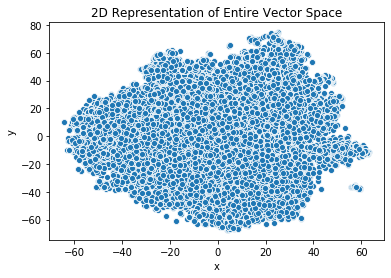

In [226]:
# Plot 2D vectorspace (not very helpful, but still cool)
sns.scatterplot(x="x", y="y", data=word_coords)
plt.title("2D Representation of Entire Vector Space")
plt.show()

In [227]:
# Plot an interactive chart of a sample of the word vectors within the vectorspace (for speed & clarity)
output_notebook()
corpus_sample = word_coords.sample(1000)
p = figure(plot_width=800, plot_height=800)
_ = p.text(x=corpus_sample["x"], y=corpus_sample["y"], text=corpus_sample["token"])
show(p)

Loading BokehJS ...

### Conclusion

I hope you enjoyed this quick review of NLP preprocessing techniques (especially the interactive word vectorspace plot at the end - that's my favorite!). 

Please leave a comment below if this helped you out or if you have suggestions for improvement.

And until next time, happy coding :)